# Introducción técnica extracción de tweets:

En este brevísimo notebook mostramos el proceso seguido para la búsqueda y extracción de los tweets enviados en fechas cercanas a las elecciones generales. 
Mostramos el caso de abril 2019 únicamente aunque realizamos el proceso tanto para abril como para noviembre. 

Tras numerosas pruebas con la cuenta de desarrollador de Twitter y diferentes librerías, encontramos que la forma más sencilla de acceder a una cantidad de tweets significativa, con el añadido de dificultad del tiempo transcurrido desde su publicación, es la librería snscrape. 

El proceso es sencillo y se explica por sí solo. 

In [4]:
# Imports
import os
import pandas as pd
import snscrape.modules.twitter as sntwitter
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from tqdm import tqdm
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Establecemos un máximo de 500000 tweets a extraer desde el 1 de abril de 2019 hasta el 29 de abril (este último día no incluido). 

En el caso de la extracción de noviembre seleccionamos más hashtag a considerar, pero ralentiza mucho el proceso y comprobamos que en casi todos los tweets relacionados con las elecciones aparece por lo menos el nombre de un partido. 

Añadimos los hashtag generales oficiales de las elecciones de abril y de los debates que fueron más comentados según los medios de comunicación. 

La búsqueda se para en 340210 tweets. consideramos que es suficiente para un análisis inicial. 

Snscrape permite la extracción de las siguientes características: 
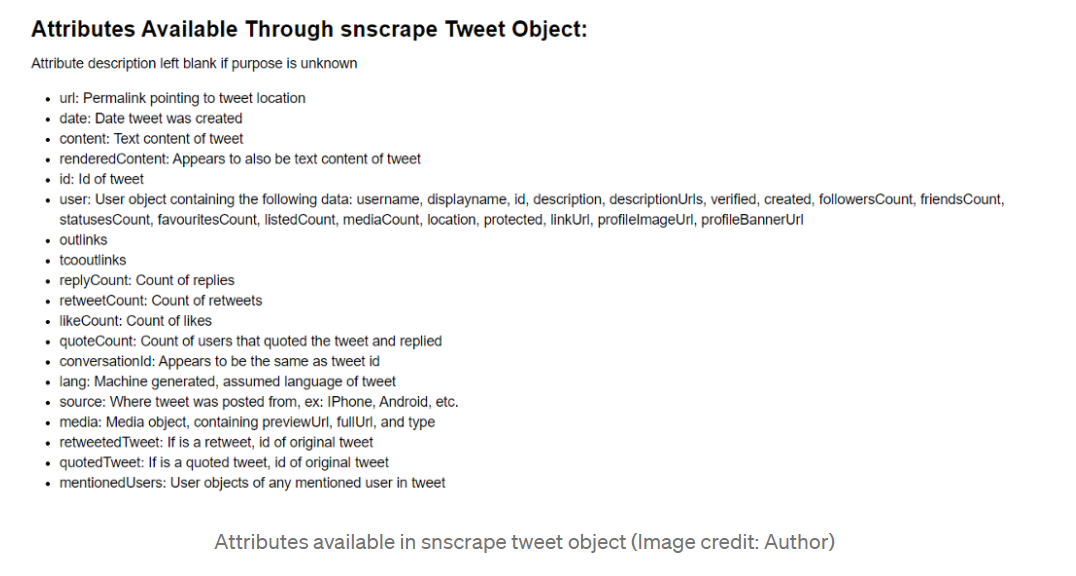

Nosotros elegimos las que creemos más relevantes para análisis futuros. 

No seleccionamos Username sino user_id para respetar la RGPD. 

En caso de publicación de nuestros resultados creemos que sería necesario además generar user_id aleatorios. 

Para más información sobre el autor de la librería: https://github.com/JustAnotherArchivist

In [5]:
# variable máximo de tweets: 
maxTweets = 500000
# lista a la que añadir los datos:
tweets_list_elecciones04_19 = []

# TwitterSearchScraper para el scraping de los datos 
for i,tweet in enumerate(tqdm(sntwitter.TwitterSearchScraper('#28A OR #ElDebateDecisivo OR #ElDebateEnRTVE OR #EleccionesGenerales28A OR #Elecciones28A OR #EleccionesL6 OR #Cs OR #Ciudadanos OR #VOX OR #PSOE OR #UnidasPodemos OR #PartidoPopular OR #PP OR @vox_es OR @PSOE OR @populares OR @CiudadanosCs OR @ahorapodemos since:2019-04-01 until:2019-04-29').get_items())):
    if i>maxTweets:
        break
    tweets_list_elecciones04_19.append([tweet.date, tweet.id, tweet.content, tweet.user.id, tweet.user.location,tweet.user.followersCount, tweet.user.friendsCount, tweet.retweetCount, tweet.replyCount, tweet.likeCount, tweet.lang, tweet.place])

# posible búsqueda adicional: topic más partidos o hechos concretos
#PorEspaña OR #EspañaViva OR #GanaPedro o #HazQuePase OR #HaciaUnMundoMejor OR #LaHistoriaLaEscribesTú OR #GanaPabloIglesias OR #SíSePuede OR #VotaPP OR #ValorSeguro OR #GanaPabloCasado OR #GanaAlbertRivera OR #VotaCiudadanos OR #SoyLiberalOR #28AUnidasPodemos OR #VamosAlbert  OR #VotaPorFavor 
# OR #UltimaOportunidadL6 OR ElDebateEnRTVE OR ElDebate4N OR DebatePresidencial OR DebateElectoral OR Debatea7RTVE OR DebateA5

Creamos dataframe de la lista anterior y lo guardamos en formato csv para poder trabajar con los tweets descargados en notebooks posteriores. 

La idea para desarrollar en versiones posteriores es tener en cuenta tanto los tweets publicados como los likes y los retweets para valorar el seguimiento de cada partido. 

En una primera versión, nos limitamos a tener en cuenta los tweets publicados. 



In [4]:
tweets_df_elecciones04_19 = pd.DataFrame(tweets_list_elecciones04_19, columns=['Datetime', 'Tweet Id', 'Text', 'Username','user_id', 'Location','followers_count','friends_count','retweet_count','reply_count','like_count','language','place'])

In [5]:
df_abril_19= pd.read_csv('tweets_df_elecciones04_19_500000.csv', delimiter=';') 

Un brevísimo análisis inicial del dataframe, ya que se investigará en otro cuaderno: 

In [9]:
#revisión de campos, nulos, etc. 
tweets_df_elecciones04_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340210 entries, 0 to 340209
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Datetime         340210 non-null  object
 1   Tweet Id         340210 non-null  int64 
 2   Text             340210 non-null  object
 3   user_id          340210 non-null  int64 
 4   Location         238217 non-null  object
 5   followers_count  340210 non-null  int64 
 6   friends_count    340210 non-null  int64 
 7   retweet_count    340210 non-null  int64 
 8   reply_count      340210 non-null  int64 
 9   like_count       340210 non-null  int64 
 10  language         340210 non-null  object
 11  place            13807 non-null   object
dtypes: int64(7), object(5)
memory usage: 31.1+ MB


Confirmamos que se ve el texto del tweet..



In [9]:
tweets_df_elecciones04_19.head(5)


Datetime             Tweet Id  \
0  2019-04-28 23:59:59+00:00  1122651707689918465   
1  2019-04-28 23:59:58+00:00  1122651702677725185   
2  2019-04-28 23:59:57+00:00  1122651699267682312   
3  2019-04-28 23:59:57+00:00  1122651698894446592   
4  2019-04-28 23:59:56+00:00  1122651694960193536   

                                                                                                                                                                                                                                                                                               Text  \
0                                                                                                                                                                    @carmencalvo_ @MyriamSempere @PSOE Muy fan de la camiseta, pero mucho más de tu feminismo, brillantez y valentía. Enhorabuena.   
1                                                                                                                                                                                                                       @MarcoMangut @PSOE @CiudadanosCs Eso tu. Aquí son las ocho de la tarde  ;-)   
2                                                                                                                                                                @Rabascoficial @marinadoate @vox_es A ti te lo voy a decir. Que quiero ser ministro algún día y estos tweets los carga el diablo 😂   
3                                                  @ElCidFostiador @vox_es No. Todos han votado a los golpistas. Estas hienas, han olido la debilidad del gobierno y han decidido sacarle partido. \nEl próximo catalán que diga eso de estamos desamparados, lo voy a mandar a reírse de su padre.   
4  @vox_es El paso ha sido grande pero no llegaremos a un futuro en las manos que quedamos,éste pais está muy ciego.En las calles se ve,perro flautas vagos, inmigrantes delincuentes y con mas derecho que los españoles y a otros los que explotan y nos quitan el trabajo y muchos separatistas.   

      user_id                   Location  followers_count  friends_count  \
0    14102996  París - Córdoba - Sevilla             2683            997   
1  2710760612              New York City             3034           1226   
2   244479652            Valencia, Spain             3678            429   
3   609842893                        NaN              903            925   
4  4046045793             Málaga, España               23            140   

   retweet_count  reply_count  like_count language place  
0              0            1           6       es   NaN  
1              0            1           1       es   NaN  
2              0            0           0       es   NaN  
3              0            0           1       es   NaN  
4              0            1           0       es   NaN

Como nuestro objetivo es cruzar los datos con los del INE por la variable Provincia o Comunidad, necesitamos ver qué opciones de tratar el apartado Location tenemos. 

Twitter no requiere que los usuarios establezcan una 'location' real ni válida, ni siquiera que se indique. 

Algunos usuarios en cambio asocian una localización a su publicación, y esta aparece en el campo 'place'.  

In [10]:
#análisis de location
tweets_df_elecciones04_19.Location.value_counts()

España                                                                                                                                               16156
Madrid                                                                                                                                                9599
Madrid, Comunidad de Madrid                                                                                                                           6348
Barcelona                                                                                                                                             4615
Madrid, España                                                                                                                                        3127
Catalunya                                                                                                                                             3035
Barcelona, España                                                     

In [11]:
#análisis de place
tweets_df_elecciones04_19.place.value_counts().head(30)

Place(fullName='Madrid, Spain', name='Madrid', type='city', country='Spain', countryCode='ES')                                            1981
Place(fullName='Barcelona, Spain', name='Barcelona', type='city', country='Spain', countryCode='ES')                                       832
Place(fullName='Seville, Spain', name='Seville', type='city', country='Spain', countryCode='ES')                                           357
Place(fullName='Valencia, Spain', name='Valencia', type='city', country='Spain', countryCode='ES')                                         332
Place(fullName='Saragossa, Spain', name='Saragossa', type='city', country='Spain', countryCode='ES')                                       281
Place(fullName='Malaga, Spain', name='Malaga', type='city', country='Spain', countryCode='ES')                                             179
Place(fullName='Granada, Spain', name='Granada', type='city', country='Spain', countryCode='ES')                                           173

Con los idiomas en principio no vamos a entrar en esta versión. Usaremos un lexicon para análisis de sentimiento únicamente en español. esto muy probablemente nos reduzca aún más el fichero...

In [12]:
#análisis de language
tweets_df_elecciones04_19.language.value_counts().head(20)

es     279690
und     23255
ca      19527
en       5079
pt       4033
it       2963
fr       1925
eu        742
de        623
in        414
et        223
nl        204
ja        185
pl        173
tl        171
ht        147
ro        119
lt         93
tr         73
hu         69
Name: language, dtype: int64

Algunos números redondos antes de pasar a otro notebook en el que empezar a limpiar oficialmente el archivo. 

In [8]:
print('El número de location distintos es: ', tweets_df_elecciones04_19['Location'].nunique())
print('El número de usuario distintos es: ', tweets_df_elecciones04_19['user_id'].nunique()) 


El número de location distintos es:  33521
El número de usuario distintos es:  123129


In [ ]:
Será necesario reducir el número de Location distintas a unas cuantas que nos sean de utilidad. 

Para el análisis que nos planteamos en un primer momento, con un tweet con sentimiento positivo frente a un partido por usuario nos parece suficiente para poder hacer una clasificación de posible intención de voto. Para ello haremos el filtrado de usuario una vez detectemos los tweets con sentimiento positivo, en el siguiente notebook.  

In [15]:
tweets_df_elecciones04_19.groupby(['Location']).nunique().sort_values('user_id', ascending= False).head(50)

Datetime  Tweet Id   Text  user_id  Location  \
Location                                                                       
España                             15308     16156  16120     4259         1   
Madrid                              9144      9599   9594     3093         1   
Madrid, Comunidad de Madrid         6148      6348   6345     2077         1   
Barcelona                           4471      4615   4612     1838         1   
Barcelona, España                   2951      2997   2997     1154         1   
Madrid, España                      3079      3127   3127     1067         1   
Catalunya                           2990      3035   3024      882         1   
Valencia, España                    2143      2168   2166      779         1   
Sevilla, España                     1989      2006   2004      768         1   
Sevilla                             1716      1736   1736      623         1   
Málaga, España                      1342      1354   1353      537         1   
Spain                               1583      1599   1598      537         1   
Comunidad de Madrid, España         1242      1245   1239      424         1   
Valencia                            1095      1100   1100      419         1   
Barcelona, Catalunya                1038      1046   1046      391         1   
Madrid, Spain                       1254      1265   1262      372         1   
Granada, España                      779       783    783      338         1   
Málaga                               923       931    930      336         1   
Zaragoza, España                     926       937    936      314         1   
Andalucía, España                   1224      1241   1241      308         1   
Murcia, España                       732       735    735      282         1   
Alicante, España                     685       695    695      231         1   
Valladolid, España                   507       508    508      217         1   
Granada                              706       712    711      216         1   
Barcelona, Cataluña                  477       477    477      213         1   
República de Catalunya               471       474    474      212         1   
Islas Canarias, España               628       631    631      209         1   
Zaragoza                             511       516    516      206         1   
Venezuela                            426       426    426      206         1   
Galicia, España                      541       541    540      205         1   
Murcia                               523       524    524      199         1   
Barcelona, Spain                     380       382    382      192         1   
madrid                               550       553    553      182         1   
Córdoba, España                      883       986    986      177         1   
Las Palmas de Gran Canaria           584       610    610      176         1   
República Catalana                   419       420    420      174         1   
ESPAÑA                               516       527    527      165         1   
Bilbao                               457       463    463      161         1   
Cataluña, España                     581       581    581      160         1   
Alicante                             458       459    459      157         1   
Madrid                               397       397    397      154         1   
españa                               592       593    591      151         1   
Santa Cruz de Tenerife, España       412       412    412      150         1   
Andalucía                            502       503    502      149         1   
València                             478       481    481      148         1   
London, England                      301       304    304      148         1   
Sevilla, Andalucía                   390       391    391      146         1   
Cádiz, España                        386       386    386      146         1   
Asturias                        

In [13]:
tweets_df_elecciones04_19.to_csv('tweets_df_elecciones04_19.csv', sep=';', index=False)


In [14]:
#para guardar el archivo en s3:
import boto3
from botocore.exceptions import ClientError

s3_client = boto3.client(
    's3',
    aws_access_key_id='XXXXX',
    aws_secret_access_key='XXXXXX',    
)

def upload_file(file_name, bucket, object_name=None):
    """Subir un archivo a un bucket
    :param file_name: archivo que hay que subir
    :param bucket: Bucket al que hay que subirlo
    :param object_name: S3 object name. Incluye la carpeta en la que hay que guardarlo. si no hay no se pone nada
    :return: True si sube el archivo, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    #s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [15]:
upload_file('tweets_df_elecciones04_19.csv',
            'electomedia',
            object_name = "EstimacionOtrasFuentes/" + 'tweets_df_elecciones04_19.csv'
           )

True